<a href="https://colab.research.google.com/github/Mahsa-Fard/House-Price-Prediction/blob/main/Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing libraries

from prompt_toolkit.widgets.dialogs import D
from bs4 import BeautifulSoup
import requests
from lxml import etree
from urllib.parse import urljoin
from io import StringIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import re

# hybel.no Scrapping

In [ ]:
data = {'type': [],
        'area': [],
        'room': [],
        'bedroom': [],
        'story': [],
        'rental period': [],
        'price': []
       }

urls = []

def crawl_information():

  root = 'https://hybel.no/bolig-til-leie/Oslo--Norge/'

  for i in range(1, 40):
    url = root + str(i)
    page_text = requests.get(root).text
    parser = etree.HTMLParser()
    html = etree.parse(StringIO(page_text), parser=parser)

    items = html.xpath('//a[@class="card card-listing card-listing-home"]')

    for item in items:
      item_url = item.get('href')
      if ('http' not in item_url):
            item_url = 'https://hybel.no' + item_url
      print(item_url)
      item_text = requests.get(item_url).text
      parser = etree.HTMLParser()
      page_html_ready = etree.parse(StringIO(item_text), parser=parser)

      properties = page_html_ready.xpath('/html/body/div[3]/div[2]/div/main/div[3]/div[2]/div[1]/div[2]')

      for prop in properties:
        property_type = prop.xpath('div[1]/ul/li[1]/span')[0].text

        data['type'].append(property_type)
        data['area'].append(prop.xpath('div[1]/ul/li[2]/span')[0].text.strip())
        pr = prop.xpath('div[2]/ul/li[1]/span')[0].text.replace(',', '')
        data['price'].append(re.sub(r"\s+", "", pr, flags=re.UNICODE))
        # print(data)
        if property_type in ('Leilighet', 'Hus'):
            data['room'].append(prop.xpath('div[1]/ul/li[3]/span')[0].text)
            data['bedroom'].append(prop.xpath('div[1]/ul/li[4]/span')[0].text)
            data['story'].append(prop.xpath('div[1]/ul/li[5]/span')[0].text)
            data['rental period'].append(prop.xpath('div[1]/ul/li[6]/span')[0].text)

        elif property_type in ('Rom i bofellesskap', 'Rom i leilighet'):
          data['room'].append(prop.xpath('div[1]/ul/li[3]/span')[0].text)
          data['bedroom'].append('')
          data['story'].append(prop.xpath('div[1]/ul/li[4]/span')[0].text)
          data['rental period'].append(prop.xpath('div[1]/ul/li[5]/span')[0].text)

        elif property_type == 'Hybel':
          data['room'].append('')
          data['bedroom'].append('')
          data['story'].append(prop.xpath('div[1]/ul/li[3]/span')[0].text)
          data['rental period'].append(prop.xpath('div[1]/ul/li[4]/span')[0].text)

        else:
            data['room'].append('')
            data['bedroom'].append('')
            data['story'].append('')
            data['rental period'].append('')

crawl_information()

# print(data)
housing = pd.DataFrame(data)

https://hybel.no/bolig/285132/rom-i-bofellesskap-nybyggerveien-19-oslo/
https://hybel.no/bolig/288109/rom-i-leilighet-knut-alvssons-vei-1-oslo-1/
https://hybel.no/bolig/288096/leilighet-3-roms-ovre-smestadvei-28c-oslo/
https://hybel.no/bolig/287895/rom-i-bofellesskap-hauketoasen-10-oslo/
https://hybel.no/bolig/288075/rom-i-leilighet-gabels-gate-47b-oslo-1/
https://hybel.no/bolig/287945/leilighet-2-roms-enebakkveien-25c-oslo/
https://hybel.no/bolig/287955/leilighet-3-roms-skedsmogata-24-oslo-2/
https://hybel.no/bolig/256553/rom-i-bofellesskap-nordahl-bruns-gate-14-oslo-22/
https://hybel.no/bolig/287882/leilighet-2-roms-thereses-gate-16d-oslo-1/
https://hybel.no/bolig/287848/rom-i-bofellesskap-hegdehaugsveien-6-oslo-1/
https://hybel.no/bolig/287807/rom-i-bofellesskap-hoyenhallveien-11-oslo-1/
https://hybel.no/bolig/287722/rom-i-bofellesskap-schweigaards-gate-44-oslo-5/
https://hybel.no/bolig/285132/rom-i-bofellesskap-nybyggerveien-19-oslo/
https://hybel.no/bolig/288109/rom-i-leilighet-kn

In [ ]:
hybel_dataset = housing.copy()

- Data Cleaning




In [ ]:
print(hybel_dataset.dtypes)
hybel_dataset.describe().T

In [ ]:
hybel_dataset['price'] = hybel_dataset['price'].str.extract('(\d+)')
hybel_dataset['area'] = hybel_dataset['area'].str.extract('(\d+)')
hybel_dataset['room'] = hybel_dataset['room'].str.extract('(\d+)')
hybel_dataset['bedroom'] = hybel_dataset['bedroom'].str.extract('(\d+)')
hybel_dataset['story'] = hybel_dataset['story'].str.extract('(\d+)')
hybel_dataset['rental period'] = hybel_dataset['rental period'].astype(str)

In [ ]:
hybel_dataset

In [ ]:
hybel_dataset.fillna(0, inplace=True)

hybel_dataset = hybel_dataset.astype({'price': 'int64', 'area': 'int64', 'room': 'int64', 'bedroom': 'int64', 'story': 'int64'})

In [ ]:
print(hybel_dataset.dtypes)
hybel_dataset.describe().T

In [ ]:
import numpy as np

# Replace NaNs with mean of the column

cols = ['room','bedroom', 'story']
hybel_dataset[cols] = hybel_dataset[cols].replace(0, np.nan)

In [ ]:
# Outlier Analysis

fig, axs = plt.subplots(2, 3, figsize = (10,5))
plt1 = sns.boxplot(hybel_dataset['price'], ax = axs[0,0])
plt2 = sns.boxplot(hybel_dataset['area'], ax = axs[0,1])
plt3 = sns.boxplot(hybel_dataset['bedroom'], ax = axs[0,2])
plt1 = sns.boxplot(hybel_dataset['room'], ax = axs[1,0])
plt2 = sns.boxplot(hybel_dataset['story'], ax = axs[1,1])

plt.tight_layout()

In [ ]:
# Filling missing values using median

hybel_dataset['room'].fillna(value = hybel_dataset['room'].median(), inplace=True)
hybel_dataset['bedroom'].fillna(value = hybel_dataset['bedroom'].median(), inplace=True)
hybel_dataset['story'].fillna(value = hybel_dataset['story'].median(), inplace=True)

In [ ]:
hybel_dataset = hybel_dataset.astype({'price': 'int64', 'area': 'int64', 'room': 'int64', 'bedroom': 'int64', 'story': 'int64'})

In [ ]:
hybel_dataset

- *Visualization*

In [ ]:
# numeric att. histogram

hybel_dataset.hist(figsize=(15, 6), layout=(2, 4));

In [ ]:
# categorical att. histogram

categoricals = ['type', 'rental period']

for item in categoricals:
  sns.catplot(x=item, kind="count", color="lightblue", data=hybel_dataset)

In [ ]:
# boxplot

# initialize figure with 2 subplots in a row
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# add padding between the subplots
plt.subplots_adjust(wspace=0.5)


# draw boxplot for station_distance in the 1st subplot
sns.boxplot(data=hybel_dataset['price'], ax=ax[0], color='g')
ax[0].set_xlabel('price')

# draw boxplot for stores_count in the 2nd subplot
sns.boxplot(data=hybel_dataset['area'], ax=ax[1], color='y')
ax[1].set_xlabel('area')


# by default, you'll see x-tick label set to 0 in each subplot
# remove it by setting it to empty list
for subplot in ax:
    subplot.set_xticklabels([])

plt.show()

In [ ]:
# heatmap

plt.figure(figsize = (16, 10))
sns.heatmap(hybel_dataset.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [ ]:
# scatter plot

sns.pairplot(hybel_dataset)
plt.show()

*dummy variables*

In [ ]:
#Get the dummy variables for the features 'type' and 'rental period' stores them in  new variables - 'propetytype', 'rentalperiod'

propetytype = pd.get_dummies(hybel_dataset['type'], drop_first = True)
propetytype

In [ ]:
rentalperiod = pd.get_dummies(hybel_dataset['rental period'])
rentalperiod

In [ ]:
#drop first columns from rentalperiod df using 'drop_first = True' so we prevent redundency

rentalperiod = pd.get_dummies(hybel_dataset['rental period'], drop_first = True)

In [ ]:
rentalperiod

In [ ]:
# add propetytype and rentalperiod columns to hybel_dataset dataframe

hybel_dataset = pd.concat([hybel_dataset, propetytype, rentalperiod], axis = 1)

In [ ]:
hybel_dataset.head()

In [ ]:
hybel_dataset[['room', 'bedroom', 'story']] = hybel_dataset[['room', 'bedroom', 'story']].astype(int)

In [ ]:
hybel_dataset

In [ ]:
hybel_dataset_cp = hybel_dataset.drop(['type', 'rental period'], axis=1)

In [ ]:
hybel_dataset_cp

- Data Transformation

In [ ]:
# Normalization

scaler = StandardScaler()
scaler.fit(hybel_dataset_cp.drop('price', axis=1))
scaled_features = scaler.transform(hybel_dataset_cp.drop('price', axis=1))
scaled_data = pd.DataFrame(scaled_features, columns = hybel_dataset_cp.drop('price', axis=1).columns)
scaled_data.head()

- Model Implementing

In [ ]:
#Split the data set into training data and test data
# Prepare training data for building the model
X = scaled_data
y = hybel_dataset_cp['price']

x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(X, y, test_size = 0.2)

#Train the model and make predictions
model = LinearRegression()
model.fit(x_training_data, y_training_data)

print(model.score(x_test_data, y_test_data))

0.9034153300860686


In [ ]:
y_predict = model.predict(x_test_data)

In [ ]:
plt.scatter(y_test_data, y_predict)
fig.suptitle('y_test vs y_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)

In [ ]:
model_1 = sm.OLS(y_training_data, x_training_data).fit()
model_1.summary()

#Finn.no Scrapping

In [ ]:
finn_data = {'type': [],
            'area': [],
            'room': [],
            'bedroom': [],
            'story': [],
            'insurance': [],
            'price': []
       }

urls = []


def crawl_information():

    url =  'https://www.finn.no/realestate/homes/search.html?lifecycle=1&location=0.20061&sort=PUBLISHED_DESC'

    while(True):
      response = requests.get(url)
      soup = BeautifulSoup(response.text, "lxml")

      next_page_element = soup.find('a', class_= 'button button--pill button--has-icon button--icon-right')

      if next_page_element:
        next_page_url = next_page_element.get('href')
        url = urljoin(url, next_page_url)
        urls.append(url)
      else:
        break


    for i in urls:
      page_text = requests.get(i).text
      parser = etree.HTMLParser()
      html = etree.parse(StringIO(page_text), parser=parser)

      items = html.xpath('//a[@class="link link--dark sf-ad-link sf-realestate-heading"]')
      # print(items)
      for item in items:
        item_url = item.get('href')
        if ('http' not in item_url):
              item_url = 'https://www.finn.no' + item_url
        print(item_url)

        item_text = requests.get(item_url).text
        parser = etree.HTMLParser()
        page = etree.parse(StringIO(item_text), parser=parser)

        try:
          finn_data['type'].append(page.xpath('//div[@data-testid="info-property-type"]/dd/text()')[0])
        except:
          finn_data['type'].append('')

        try:
          finn_data['area'].append(page.xpath('//div[@data-testid="info-usable-area"]/dd/text()')[0])
        except:
          finn_data['area'].append('')

        try:
          price = page.xpath('//div[@data-testid="pricing-total-price"]/dd/text()')[0]
          finn_data['price'].append(re.sub(r"\s+", "", price, flags=re.UNICODE))
        except:
          finn_data['price'].append('')

        try:
          finn_data['room'].append(page.xpath('//div[@data-testid="info-rooms"]/dd/text()')[0])
        except:
          finn_data['room'].append('')

        try:
          finn_data['bedroom'].append(page.xpath('//div[@data-testid="info-bedrooms"]/dd/text()')[0])
        except:
          finn_data['bedroom'].append('')

        try:
          finn_data['story'].append(page.xpath('//div[@data-testid="info-floor"]/dd/text()')[0])
        except:
          finn_data['story'].append('')

        try:
          finn_data['insurance'].append(page.xpath('//div[@data-testid="info-change-ownership-insurance"]/dd/text()')[0])
        except:
          finn_data['insurance'].append('')



crawl_information()

finn_dataset = pd.DataFrame(finn_data)
# print(urls)
# print(data)
# finn_houses = pd.DataFrame(finn_data, index=[0])

https://www.finn.no/realestate/homes/ad.html?finnkode=278357683
https://www.finn.no/realestate/homes/ad.html?finnkode=279053688
https://www.finn.no/realestate/homes/ad.html?finnkode=278745986
https://www.finn.no/realestate/homes/ad.html?finnkode=278871188
https://www.finn.no/realestate/homes/ad.html?finnkode=278833816
https://www.finn.no/realestate/homes/ad.html?finnkode=279047261
https://www.finn.no/realestate/homes/ad.html?finnkode=279048955
https://www.finn.no/realestate/homes/ad.html?finnkode=279047572
https://www.finn.no/realestate/homes/ad.html?finnkode=279045096
https://www.finn.no/realestate/homes/ad.html?finnkode=278747886
https://www.finn.no/realestate/homes/ad.html?finnkode=275226698
https://www.finn.no/realestate/homes/ad.html?finnkode=279042914
https://www.finn.no/realestate/homes/ad.html?finnkode=274294478
https://www.finn.no/realestate/homes/ad.html?finnkode=276289893
https://www.finn.no/realestate/homes/ad.html?finnkode=278770818
https://www.finn.no/realestate/homes/ad.

In [ ]:
finn_dataset

- Data Cleaning



In [ ]:
#extracts numeric values

finn_dataset['area'] = finn_dataset['area'].str.extract('(\d+)')
finn_dataset['price'] = finn_dataset['price'].str.extract('(\d+)')

In [ ]:
import numpy as np

finn_dataset = finn_dataset.replace(r'^\s*$', np.nan, regex=True)

In [ ]:
#Removes rows where type value are NaN
finn_dataset = finn_dataset.dropna(how='all')

In [ ]:
finn_dataset

In [ ]:
finn_dataset.isna().sum()

In [ ]:
cols = ['story', 'room', 'bedroom', 'area', 'price']
finn_dataset[cols] = finn_dataset[cols].replace(np.nan, '-10')

#fills missing values of insurance column with 'ikke nevnt'
finn_dataset['insurance'] = finn_dataset['insurance'].replace(np.nan, 'ikke nevnt')

#converts types
finn_dataset = finn_dataset.astype({'type': 'str', 'area': 'int64', 'room': 'int64', 'bedroom': 'int64', 'story': 'int64', 'insurance': 'str', 'price': 'int64'})

finn_dataset[cols] = finn_dataset[cols].replace(-10, np.nan)

In [ ]:
print(finn_dataset.dtypes)
finn_dataset.describe().T

*Label Encoding*



In [ ]:
finn_dataset['type'].value_counts()

Leilighet                1496
Enebolig                  180
Tomannsbolig               90
Rekkehus                   75
Garasje/Parkering          48
Andre                       9
Tomter                      1
Bygård/Flermannsbolig       1
Kontor                      1
Name: type, dtype: int64

In [ ]:
finn_dataset["type"] = finn_dataset["type"].astype('category')
finn_dataset["type_cat"] = finn_dataset["type"].cat.codes

In [ ]:
insurance = pd.get_dummies(finn_dataset['insurance'])
insurance = insurance.drop(['ikke nevnt'], axis=1)
insurance.rename(columns = {'Ja': 'has_insurance'}, inplace = True)

In [ ]:
finn_dataset = pd.concat([finn_dataset, insurance], axis = 1)

In [ ]:
finn_dataset

,type,area,room,bedroom,story,insurance,price,type_cat,has_insurance
0,Enebolig,189.0,7.0,4.0,NaN,ikke nevnt,18348877.0,2,0
1,Enebolig,173.0,NaN,4.0,NaN,Ja,9498920.0,2,1
2,Leilighet,83.0,4.0,3.0,2.0,ikke nevnt,7902605.0,5,0
3,Leilighet,80.0,3.0,2.0,1.0,ikke nevnt,NaN,5,0
4,Leilighet,48.0,2.0,1.0,1.0,ikke nevnt,NaN,5,0
...,...,...,...,...,...,...,...,...,...
2149,Garasje/Parkering,15.0,0.0,0.0,NaN,Ja,294900.0,3,1
2151,Garasje/Parkering,12.0,0.0,0.0,NaN,ikke nevnt,257502.0,3,0
2152,Garasje/Parkering,1.0,0.0,0.0,NaN,ikke nevnt,670210.0,3,0
2154,Garasje/Parkering,18.0,0.0,0.0,1.0,ikke nevnt,478000.0,3,0


*Missing Values*

In [ ]:
finn_dataset.loc[finn_dataset['type'] == 'Garasje/Parkering', 'room'] = 0
finn_dataset.loc[finn_dataset['type'] == 'Garasje/Parkering', 'bedroom'] = 0

In [ ]:
from sklearn.impute import KNNImputer

df = finn_dataset.drop(['type', 'insurance'], axis=1)

imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(imputed, columns=df.columns)

In [ ]:
df_imputed

,area,room,bedroom,story,price,type_cat,has_insurance
0,189.0,7.0,4.0,1.6,18348877.0,2.0,0.0
1,173.0,3.6,4.0,1.6,9498920.0,2.0,1.0
2,83.0,4.0,3.0,2.0,7902605.0,5.0,0.0
3,80.0,3.0,2.0,1.0,6394707.4,5.0,0.0
4,48.0,2.0,1.0,1.0,3798537.4,5.0,0.0
...,...,...,...,...,...,...,...
1896,15.0,0.0,0.0,1.4,294900.0,3.0,1.0
1897,12.0,0.0,0.0,1.4,257502.0,3.0,0.0
1898,1.0,0.0,0.0,1.0,670210.0,3.0,0.0
1899,18.0,0.0,0.0,1.0,478000.0,3.0,0.0


In [ ]:
df_imputed = df_imputed.astype({'area': 'int64', 'room': 'int64', 'bedroom': 'int64', 'story': 'int64', 'price': 'int64',
                                    'type_cat': 'int64', 'has_insurance': 'int64'})

In [ ]:
df_imputed.isna().sum()

area             0
room             0
bedroom          0
story            0
price            0
type_cat         0
has_insurance    0
dtype: int64

In [ ]:
cols = ['story', 'room', 'bedroom']

df_imputed[cols] = df_imputed[cols].apply(np.floor)

In [ ]:
df_imputed

In [ ]:
finn_dataset = pd.concat([finn_dataset['type'], finn_dataset['insurance'], df_imputed], axis = 1)

In [ ]:
finn_dataset

*correlation*

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize = (16, 10))
sns.heatmap(df_imputed.corr(), annot = True, cmap="YlGnBu")
plt.show()

*barplot*

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


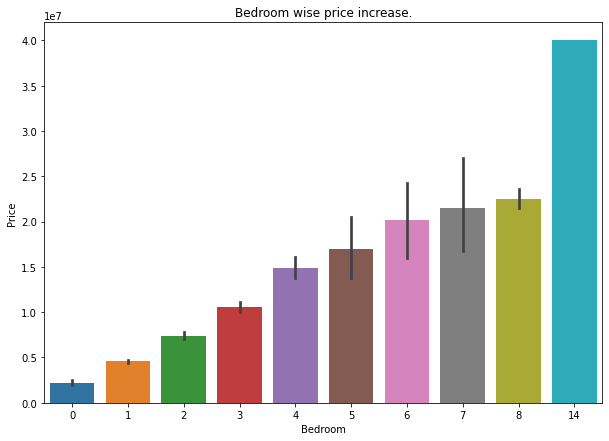

In [ ]:
# barplot show

plt.figure(figsize=(10, 7))
plt.title("Bedroom wise price increase.")

sns.barplot('bedroom', 'price', data=df_imputed)
plt.xlabel('Bedroom', )
plt.ylabel('Price')
plt.show()

In [ ]:
# barplot show

plt.figure(figsize=(10, 7))
plt.title("room wise price increase.")

sns.barplot('room', 'price', data=df_imputed)
plt.xlabel('room', )
plt.ylabel('Price')
plt.show()

*distribution diagram*

In [ ]:
sns.distplot(df_imputed['price'])

*scatter plot*

In [ ]:
# scatter plot

sns.pairplot(finn_dataset)
plt.show()

In [ ]:
sns.catplot(y="type", kind="count", color="lightblue", data=finn_dataset)

 *Outlier Treatment*





In [ ]:
# find q1 and q3 values
Q1, Q3 = np.percentile(sorted(df_imputed['price']), [25, 75])

# compute IRQ
IQR = Q3 - Q1

# find lower and upper bounds
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

df_imputed = df_imputed[(df_imputed['price'] >= Q1 - 1.5*IQR) & (df_imputed['price'] <= Q3 + 1.5*IQR)]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# find q1 and q3 values
Q1, Q3 = np.percentile(sorted(df_imputed['area']), [25, 75])

# compute IRQ
IQR = Q3 - Q1

# find lower and upper bounds
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

df_imputed = df_imputed[(df_imputed['area'] >= Q1 - 1.5*IQR) & (df_imputed['area'] <= Q3 + 1.5*IQR)]

In [ ]:
df_imputed

In [ ]:
df_imputed[['room', 'bedroom', 'story', 'has_insurance']] = df_imputed[['room', 'bedroom', 'story', 'has_insurance']].astype(int)

- Data Transformation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

scaler = StandardScaler()
scaler.fit(df_imputed.drop('price', axis=1))
scaled_features = scaler.transform(df_imputed.drop('price', axis=1))
scaled_data = pd.DataFrame(scaled_features, columns = df_imputed.drop('price', axis=1).columns)
scaled_data.head()

,area,room,bedroom,story,type_cat,has_insurance
0,0.282008,1.087396,1.183244,-0.480592,0.06225,-0.601446
1,0.188095,0.183082,0.129316,-0.978916,0.06225,-0.601446
2,-0.813645,-0.721232,-0.924611,-0.978916,0.06225,-0.601446
3,-1.001471,0.183082,0.129316,-0.480592,0.06225,1.662659
4,-1.251906,-1.625547,-0.924611,1.014379,0.06225,-0.601446


- Model Implementing

In [ ]:
#Split the data set into training data and test data
# Prepare training data for building the model
X = scaled_data
y = df_imputed['price']

x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(X, y, test_size = 0.2)


#Train the model and make predictions
model = LinearRegression()
model.fit(x_training_data, y_training_data)

print(model.score(x_test_data, y_test_data))

0.6190665116063498


In [ ]:
y_predict = model.predict(x_test_data)

In [ ]:
plt.scatter(y_test_data, y_predict)
fig.suptitle('y_test vs y_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)